In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import random
import math

# Voting patterns of 6 one-seat parties

The amendment of the laws on the MP election from using one to using two ballots has made it difficult for small parties to gain foothold in an election. Prior to the amendment, parties receiving at least $50,000$ votes ($0.2\%$ of total votes) nationwide won a party-list seat. In contrast, $350,000$ votes translate to one seat under the current system, which reduces the number of one-seat parties to $7$. Excluding the the Thai Liberal Party (Seri Ruam Thai), which had obtained $10$ party-list seats in the 2019 election, other six parties gained one party-list seat. Pumjai Chatmaitri has observed the following common trends between the the 

In [214]:
party_result_id = result_party[result_party["party_id"] == id].set_index("cons_id")

,party_id,party_list_vote,party_list_vote_percent
cons_id,,,
ACR_1,773,371,0.35141
ACR_2,773,649,0.58043
ATG_1,773,107,0.11921
ATG_2,773,210,0.22959
AYA_1,773,128,0.11603
...,...,...,...
YLA_2,773,92,0.09171
YLA_3,773,68,0.06942
YST_1,773,277,0.25070


In [195]:
def getProv(cons_id):
    return cons_id.split("_")[0]

def getConst_No(cons_id):
    return int(cons_id.split("_")[1])

def isMajorParty(party_id):
    assert party_id >= 700 and party_id <= 800
    cons_lst = [701,706,707,709,743,763]
    prog_lst = [705,726,762,719,740,773]
    if (party_id not in cons_lst) and (party_id not in prog_lst):
        return False
    else:
        return True

def getComparison(cons_id_toExamine, all_cons_id, method = "province"):
    # A function to create a comparison group
    """
    @cons_id_toExamine: The list of constituency id that we want to examine because of some interesting or suspicious pattern
    @all_cons_id: The list of all constituency id that are potential comparison group(i.e. sample space)
    @method: The method to find the comparison group. The options are by province, by size, and by region. 
    """
    assert method in ["province", "size", "region"]
    if(method == "province"):
        prov_lst = [getProv(cons_id) for cons_id in cons_id_toExamine]
        return [cons_id for cons_id in all_cons_id if cons_id.split("_")[0] in prov_lst]

def getRGB(length):
    # Get random colors
    rgbLst = []
    round = math.floor(length/3)
    for i in range(round):
        initial = np.random.randint(low=0, high=255, size=3)/255
        rgbLst.append(initial)
        rgbLst.append(np.roll(initial,1))
        rgbLst.append(np.roll(initial,2))

    # Add the remaining color
    remain = length-(round*3)
    initial = np.random.randint(low=0, high=255, size=3)/255
    for j in range(remain):
        rgbLst.append(np.roll(initial,j))

    return rgbLst

In [2]:
# Read all dataframe from 9geek website.
# c = constituency; candi = candidate
pwd = "9geek_dataset/"
info_c9 = pd.read_csv(pwd + "info_constituency9.csv")
info_party9 = pd.read_csv(pwd + "info_party9.csv")
info_province9 = pd.read_csv(pwd + "info_province9.csv")
result_partylist9 = pd.read_csv(pwd + "result_partylist9.csv")
result_cstatus9 = pd.read_csv(pwd + "result_constituency_status9.csv")
result_candi9 = pd.read_csv(pwd + "result_candidate9.csv")

# Read my personal dataframe
info_province = pd.read_csv("PL_info_province.csv")
result_candi = pd.read_csv("PL_result_constituencies_CandidateConst.csv")
result_party = pd.read_csv("PL_result_constituencies_PartylistConst.csv")
result_overall = pd.read_csv("PL_result_constituencies_Overall.csv").rename(columns = {"Unnamed: 0":"cons_id"})
result_overall = result_overall.drop(columns = result_overall.columns.tolist()[4:]).set_index("cons_id")

In [3]:
# Create a map between party ID, color, and name
id_name = dict(zip(info_party9["id"], info_party9["name"]))
id_no = dict(zip(info_party9["id"], info_party9["party_no"]))
party_color_map = dict(zip(info_party9["id"], info_party9["color"]))

In [216]:
# Subset the partylist result to obtain the number of partylist votes each party obtains
id = 761
partylist_no = id_no[id]
party_result_id = result_party[result_party["party_id"] == id].set_index("cons_id")

party_result_id

,party_id,party_list_vote,party_list_vote_percent
cons_id,,,
ACR_1,761,672,0.63652
ACR_2,761,263,0.23521
ATG_1,761,95,0.10584
ATG_2,761,147,0.16072
AYA_1,761,422,0.38253
...,...,...,...
YLA_2,761,2470,2.46215
YLA_3,761,55,0.05615
YST_1,761,391,0.35387


In [217]:
# Identify the vote and the party affiliation constituent candidates with the same number receive 
candi_same_id = [cons_id + "_%s" %(int(partylist_no)) for cons_id in party_result_id.index.tolist()]

temp = result_candi[result_candi["mp_app_id"].isin(candi_same_id)].set_index("cons_id").drop(columns=["mp_app_rank","percent","mp_app_id"])
temp = temp.rename({"party_id":"party_id_CandidateConst", "mp_app_vote":"CandidateConst_vote"}, axis=1)

In [218]:
# Join the dataframe of party list vote and candidate constituion vote
party_result_id = party_result_id.join(temp)

In [219]:
# Modify the party color map so that every non-major party (i.e., doesn't win any candidate constituency seat)
# receives the same color
cons_lst = [701,706,707,709,743,763]
prog_lst = [705,726,762,719,740,773] 
for id in result_candi["party_id"].unique():
    if id not in cons_lst and id not in prog_lst:
        party_color_map[id] = "#000000"
party_result_id

,party_id,party_list_vote,party_list_vote_percent,CandidateConst_vote,party_id_CandidateConst
cons_id,,,,,
ACR_1,761,672,0.63652,15926,701
ACR_2,761,263,0.23521,2530,701
ATG_1,761,95,0.10584,618,743
ATG_2,761,147,0.16072,816,743
AYA_1,761,422,0.38253,15289,705
...,...,...,...,...,...
YLA_2,761,2470,2.46215,24611,743
YLA_3,761,55,0.05615,210,721
YST_1,761,391,0.35387,13394,705


In [1]:
# Mark if a district is economically prosperous
status_lst = []
major_prov = ["BKK", "NBI", "RYG", "PTE","SPK","CBI"]

for cons_id in party_result_id.index.tolist():
    prov = cons_id.split("_")[0]
    cons_no = int(cons_id.split("_")[1])
    if prov in major_prov:
        status_lst.append(2)
    elif(cons_no == 1):
        status_lst.append(1)
    else:
        status_lst.append(0)
party_result_id["status"] = status_lst

NameError: name 'party_result_id' is not defined

In [2]:
ax = plt.subplots(figsize = (10,10))
marker_lst = [".","+","*"]
alpha_lst = [1,1,1]
type = ["Other", "District 1", "Major province"]
size_lst = [100, 100, 100]


for i, level in enumerate(party_result_id["status"].unique()):
    temp = party_result_id[party_result_id["status"] == level]
    plt.scatter(temp["CandidateConst_vote"], 
                temp["party_list_vote"], 
                c =temp["party_id_CandidateConst"].map(party_color_map),
                marker = marker_lst[i],
                label = type[i],
                s = size_lst[i],
                alpha = alpha_lst[i])
        
plt.xlabel("Votes for constituency candidate Number %i" %(partylist_no))
plt.ylabel("Party list vote")
plt.title("Party list votes and candidate constituency votes with the same number (%s)" %(int(partylist_no)))
plt.xticks(np.arange(0,70000,10000))
plt.yticks(np.arange(0,5000,250))
plt.legend()


NameError: name 'plt' is not defined

In [104]:
info_party9

,id,party_no,name,abbr,color,logo_url
0,701,26.0,ประชาธิปัตย์,ปชป.,#06aff3,https://cdn.ectreport.com/images/logos/ประชาธิ...
1,702,63.0,ประชากรไทย,ปชท.,#0f41ce,https://cdn.ectreport.com/images/logos/ประชากร...
2,703,60.0,ความหวังใหม่,ควม.,#e6b750,https://cdn.ectreport.com/images/logos/ความหวั...
3,705,29.0,เพื่อไทย,พท.,#da3731,https://cdn.ectreport.com/images/logos/เพื่อไท...
4,706,14.0,ชาติพัฒนากล้า,ชพก.,#233e8a,https://cdn.ectreport.com/images/logos/ชาติพัฒ...
...,...,...,...,...,...,...
65,780,55.0,ไทยก้าวหน้า,ทกน.,#b9bee3,https://cdn.ectreport.com/images/logos/ไทยก้าว...
66,781,9.0,พลัง,พ.,#8e8fc7,https://cdn.ectreport.com/images/logos/พลัง.png
67,783,52.0,ชาติรุ่งเรือง,ชรร.,#9cb4c9,https://cdn.ectreport.com/images/logos/ชาติรุ่...
68,784,23.0,รวมใจไทย,ร.จ.ท.,#eec49a,https://cdn.ectreport.com/images/logos/รวมใจไท...


[0.15294118 0.44313725 0.68235294]
[0.68235294 0.15294118 0.44313725]
[0.44313725 0.68235294 0.15294118]


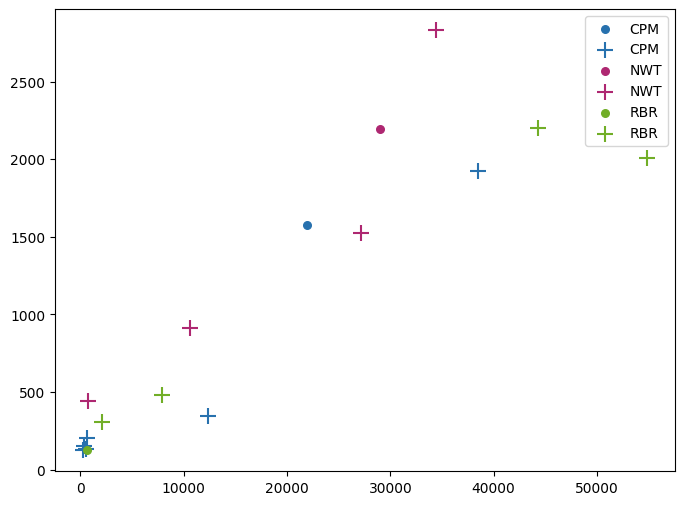

In [207]:
# Check the hypothesis by subsetting districts with highest votes
highest_cons_id = party_result_id.sort_values("party_list_vote", ascending=False)[12:15]

# Find the province that contains constituency where a small party receives the highest vote
with_control = getComparison(highest_cons_id.index.tolist(), party_result_id.index.tolist(), method="province")

# Create a marker where constituency candidate is from a major party
party_result_id["isMajor_CandidateConst"] = [isMajorParty(party_id) for party_id in np.array(party_result_id["party_id_CandidateConst"])]

# Subset the dataframe to contain only comparison id
to_plot_df = party_result_id.loc[with_control]
to_plot_df["province"] = [getProv(cons_id) for cons_id in to_plot_df.index.tolist()]

# Plot the graph of major province 
color_lst = getRGB(len(to_plot_df["province"].unique()))
ax = plt.subplots(figsize=(8,6))
size = 120
marker_lst = [".", "+", "*"]

for i, province_name in enumerate(to_plot_df["province"].unique()):
    province_df = to_plot_df[to_plot_df["province"] == province_name]
    print(color_lst[i])
    # Create a scatterplot
    for j, status_no in enumerate(province_df["status"].unique()):
        temp = province_df[province_df["status"] == status_no]
        plt.scatter(temp["CandidateConst_vote"], 
                    temp["party_list_vote"], 
                    color = color_lst[i],
                    label = province_name,
                    marker = marker_lst[j],
                    s = size)
plt.legend()

In [171]:
highest_cons_id

,party_id,party_list_vote,party_list_vote_percent,CandidateConst_vote,party_id_CandidateConst,status,isMajor_CandidateConst
cons_id,,,,,,,
PNB_6,747,3379,3.60457,47118,743,0,True
KPT_3,747,2933,3.10029,37149,743,0,True
NWT_3,747,2830,3.51938,34411,743,0,True
PNB_4,747,2765,3.19432,41039,743,0,True
SRN_8,747,2762,3.02758,39558,709,0,True


In [156]:
to_plot_df

,party_id,party_list_vote,party_list_vote_percent,CandidateConst_vote,party_id_CandidateConst,status,isMajor_CandidateConst,province
cons_id,,,,,,,,
AYA_1,747,83,0.07524,621,762,1,True,AYA
AYA_2,747,246,0.23002,4370,763,0,True,AYA
AYA_3,747,2356,2.18354,47117,709,0,True,AYA
AYA_4,747,106,0.09302,2939,763,0,True,AYA
AYA_5,747,256,0.23874,22100,726,0,True,AYA
BRM_1,747,91,0.10051,1847,763,1,True,BRM
BRM_10,747,190,0.23003,329,719,0,True,BRM
BRM_2,747,134,0.15161,1324,763,0,True,BRM
BRM_3,747,109,0.12989,473,719,0,True,BRM


In [120]:
to_plot_df

,party_id,party_list_vote,party_list_vote_percent,CandidateConst_vote,party_id_CandidateConst,status,isMajor_CandidateConst,province
cons_id,,,,,,,,
AYA_1,747,83,0.07524,621,762,1,True,AYA
AYA_2,747,246,0.23002,4370,763,0,True,AYA
AYA_3,747,2356,2.18354,47117,709,0,True,AYA
AYA_4,747,106,0.09302,2939,763,0,True,AYA
AYA_5,747,256,0.23874,22100,726,0,True,AYA
BRM_1,747,91,0.10051,1847,763,1,True,BRM
BRM_10,747,190,0.23003,329,719,0,True,BRM
BRM_2,747,134,0.15161,1324,763,0,True,BRM
BRM_3,747,109,0.12989,473,719,0,True,BRM


In [262]:
y, X = dmatrices("party_list_vote ~ candi_same_id_vote*isMajor", data = party_result_id, return_type='dataframe')

In [263]:
mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:        party_list_vote   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     218.4
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           7.87e-80
Time:                        17:08:42   Log-Likelihood:                -2593.8
No. Observations:                 354   AIC:                             5196.
Df Residuals:                     350   BIC:                             5211.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [100]:
party_result_id

,party_id,party_list_vote,party_list_vote_percent,CandidateConst_vote,party_id_CandidateConst,status,isMajor_CandidateConst
cons_id,,,,,,,
ACR_1,747,219,0.20744,2701,763,1,True
ACR_2,747,647,0.57864,17637,705,0,True
ATG_1,747,92,0.10250,1602,763,1,True
ATG_2,747,98,0.10714,194,733,0,False
AYA_1,747,83,0.07524,621,762,1,True
...,...,...,...,...,...,...,...
YLA_2,747,526,0.52433,453,739,0,False
YLA_3,747,480,0.49002,401,762,0,True
YST_1,747,112,0.10137,369,719,1,True


In [157]:
import random